In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt

import itertools
import copy

In [ ]:
transformers = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], # mean imagenet
                         [0.229, 0.224, 0.225]) # std imagenet
])

In [ ]:
dataset_colorectal_cancer = datasets.ImageFolder(root = ("/content/drive/MyDrive/PhD/Courses/ML/Project/Codes/Dataset/Dataset_1/Colorectal_Cancer"),
transform = transformers)

In [ ]:
print(dataset_colorectal_cancer)

Dataset ImageFolder
    Number of datapoints: 6000
    Root location: /content/drive/MyDrive/PhD/Courses/ML/Project/Codes/Dataset/Dataset_1/Colorectal_Cancer
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [ ]:
train_ind, test_ind = train_test_split(list(range(len(dataset_colorectal_cancer.targets))),
                                       test_size=0.3, random_state = 0,stratify=dataset_colorectal_cancer.targets)

In [ ]:
train_set = torch.utils.data.Subset(dataset_colorectal_cancer, train_ind)
test_set = torch.utils.data.Subset(dataset_colorectal_cancer, test_ind)

In [ ]:
print(len(train_set))
print(len(test_set))

4200
1800


In [ ]:
batch_size = 32

In [ ]:
train_loader = DataLoader(train_set, shuffle=True, batch_size = batch_size, pin_memory = True) # create train loader
test_loader = DataLoader(test_set, batch_size = batch_size, pin_memory = True) # create test loader

In [ ]:
model_resnet18 = models.resnet18()
# Modify the fully connected (fc) layer for 3-class classification
num_features = model_resnet18.fc.in_features
model_resnet18.fc = torch.nn.Linear(num_features, 3)
# Print the modified model to verify the changes
print(model_resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_epoch = 100
device = "cuda:0" # use 'cuda:0' to speed it up.
lr = 0.01

In [ ]:
model_resnet18_training = copy.deepcopy(model_resnet18)
model_resnet18_training.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Define opt function and learning rate
optimizer = torch.optim.SGD(model_resnet18_training.parameters(), lr=lr)

# Define loss function and training criterion
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
train_data_metrics = []
test_data_metrics = []

In [ ]:
# Training
for epoch in range(num_epoch):
    model_resnet18_training.train()
    train_loss = 0.0
    correct_train = 0.0
    total_train = 0.0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        out_preds = model_resnet18_training(inputs)
        l = criterion(out_preds, labels)

        model_resnet18_training.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.item()
        _, predicted_train = torch.max(out_preds.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    train_loss /= len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_data_metrics.append([epoch+1, train_loss, train_accuracy])
    # Test
    model_resnet18_training.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_resnet18_training(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted_val = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_val == labels).sum().item()

    # Calculate validation metrics
    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_data_metrics.append([epoch+1, test_loss, test_accuracy])
    # Print training and validation metrics for this epoch
    print(f"Epoch [{epoch+1}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Epoch [1], Training Loss: 0.6365, Training Accuracy: 71.86%, Test Loss: 0.8736, Test Accuracy: 67.89%
Epoch [2], Training Loss: 0.3633, Training Accuracy: 86.02%, Test Loss: 0.8991, Test Accuracy: 67.33%
Epoch [3], Training Loss: 0.2963, Training Accuracy: 88.52%, Test Loss: 1.1988, Test Accuracy: 66.72%
Epoch [4], Training Loss: 0.2347, Training Accuracy: 91.29%, Test Loss: 1.1776, Test Accuracy: 69.89%
Epoch [5], Training Loss: 0.2039, Training Accuracy: 92.17%, Test Loss: 0.3268, Test Accuracy: 88.11%
Epoch [6], Training Loss: 0.1721, Training Accuracy: 93.81%, Test Loss: 0.3053, Test Accuracy: 90.83%
Epoch [7], Training Loss: 0.1310, Training Accuracy: 95.64%, Test Loss: 0.5676, Test Accuracy: 80.67%
Epoch [8], Training Loss: 0.1297, Training Accuracy: 95.12%, Test Loss: 0.3071, Test Accuracy: 87.94%
Epoch [9], Training Loss: 0.1091, Training Accuracy: 96.02%, Test Loss: 0.2335, Test Accuracy: 92.94%
Epoch [10], Training Loss: 0.1189, Training Accuracy: 95.62%, Test Loss: 0.2441, T

In [ ]:
df_train = pd.DataFrame(train_data_metrics, columns = ["epoch", "train_loss", "train_accuracy"])
df_test = pd.DataFrame(test_data_metrics, columns = ["epoch", "test_loss", "test_accuracy"])

In [ ]:
df_train.to_csv("df_train.csv")
df_test.to_csv("df_test.csv")

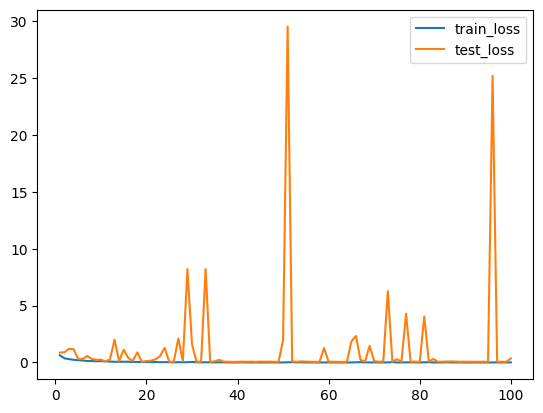

In [ ]:
plt.plot(df_train["epoch"], df_train["train_loss"], label = "train_loss")
plt.plot(df_test["epoch"], df_test["test_loss"], label = "test_loss")
plt.legend()

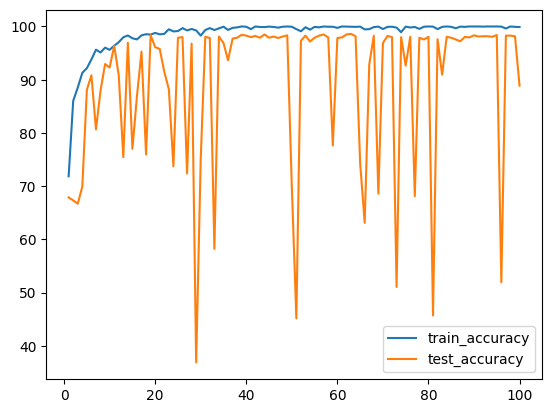

In [ ]:
plt.plot(df_train["epoch"], df_train["train_accuracy"], label = "train_accuracy")
plt.plot(df_test["epoch"], df_test["test_accuracy"], label = "test_accuracy")
plt.legend()